# Optimal Liquidation of Assets

Click here for an interactive version of this notebook:-
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/pjohno/MSc-Math-Finance-2018/master?filepath=notebooks%2FMSc%20Project%204%20-%20Optimal%20Liquidation.ipynb)

Here we follow the Gueant at al. (2013) paper. Their model can be outlined as follows. First assume that the reference price of the asset follows a Brownian motion
$$
dS = \mu dt + \sigma dW
$$
and assume that a trader tries to sell the asset by posting an ask price $S_a$ on the market, so that
$$
S_a = S + \delta.
$$
Now assume that the trader holds $q_t$ assets at time $t$, and the sale of each asset follows a Poisson process such that
$$
q_t = q_0 - N_t
$$
and the arrival rate of jumps $\lambda$ in the Poisson process depends on the choice of $\delta$,
$$
\lambda(\delta) = \exp(-k\delta),
$$
so that the higher the ask price the lower the probability of a sale.

Then the cash process of the trader evolves as
$$
dX = (S + \delta) N_t
$$
and the trader who maximises their expected utility solves
$$
\sup_{\delta} E\left[ -\exp(-\gamma (X_T - q_T (S-b))) \right]
$$
    where $\gamma$ is their risk aversion, $X_T$ is total cash at maturity, $q_T$ is assets remaining at $T$ that are sold at a discount $(S-b)$.
    
It turns out that this problem has an analytic solution, which we can find by assuming that the value of the expected utility $u(S,X,q,t)$ can be written as
$$
u(S,X,q,t) = -\exp(-\gamma(x+qS)) w(q,t)^{\gamma/k} .
$$
This allows the solution to be found from a series of ODEs,
$$
\frac{dw}{dt} = (\alpha q^2 - \beta q) w(q,t) - \eta w(q-1,t)
$$
with
$$
w(0,t) =0
$$
and
$$
w(q,T) = e^{-kqb}.
$$
We can solve these ODEs easily using any integrating method we choose.

Here I've included a library which allows for the addition and scalar multiplication of vectors. This allows for integration formula to be written in template form with ease. I can provide a c++ file with everything in [click here](https://github.com/pjohno/MSc-Math-Finance-2018/tree/master/main/project-4-optimal-liquidation-all-in-one.cpp), which should produce a results file for the graph below.

To start the code we include a few libraries:

In [1]:
#include "msc_project_4.hpp"

Next we declare the parameters in the problem. We are going to solve for $w(q,t)$ and $\delta(q,t)$ and we are going to store values for all times and $q$ values. To make things easier we are going to reference $q$ and $t$ as
$$
w(q,t^i) = \omega_{i,q} 
$$
which in code is `omega[i][q]` and
$$
\delta(q,t^i) = \delta_{i,q} 
$$
in code `delta[i][q]`. This makes the integration at each time easier to handle. We split the total time $T$ into $n$ observations, but allow later the possibility that the integration is over multiple steps inbetween.


In [2]:
// ONLY RUN THIS CELL ONCE AT THE START
// Model parameters
int qMax;
double mu,sigma,A,k,Gamma,b,T;
  
// number of time observations
int n;
// time step
double dT = T/n;
// store the value of the omega and delta at each time step and q value
std::vector<MVector> omega,delta;

Now we set up the parameters to reflect the choices in figure 1 of the paper

In [3]:
// can change any of these parameters and get the results
qMax=6;
mu=0.0;
sigma=0.3;
A = 0.1;
k=0.3;
Gamma = 0.05;
b=3;
T= 300;
n=100;
// time step
dT = T/n;
omega.clear();
omega.resize(n+1,MVector(qMax+1));
delta.clear();
delta.resize(n+1,MVector(qMax+1));

and set up the initial conditions

In [4]:
// initialise the solution at t=T
  for(int q=0;q<=qMax;q++)
  {
    // from initial condition
    omega[n][q] = exp(-k*q*b);
    // from formula for delta
    if(q>0)
      delta[n][q] = 1/k*log(omega[n][q]/omega[n][q-1]) + 1/Gamma*log(1+Gamma/k);
    else
      delta[n][q] = 0.;
  }

Next we initiate the integration. We do this by assuming we solve a problem of the form
$$
\frac{d \mathbf{w}}{dt} = \mathbf{F}(\mathbf{w},t)
$$
where $\mathbf{w}$ is a vector (in $\mathbb{R}^q$ space).

In [5]:
// now use a numerical integration to find the value at T_i given the value at T_{i+1}
  for(int i = n-1 ; i>=0 ; i--)
  {
    // some constants in the equation
    double alpha = k/2.*Gamma*sigma*sigma;
    double beta = k*mu;
    double eta = A*pow(1+Gamma/k,-(1+k/Gamma));
    // now solve 
    //   dw(q,t)/dt = (alpha q^2 - beta q) w(q,t) - eta w(q-1,t)
    // with initial condition 
    //   w(q,T_i) = omega(q,T_i)
    // so that
    //   omega(q,T_{i-1}) = w(q,T_{i-1})
    omega[i] = RK4MethodTemplate(100,i*dT,(i-1)*dT,omega[i+1],
         [&]
         (const  MVector &w,double t)
         {
           MVector F(qMax+1);
           F[0] = 0.;
           for(int q=1;q<=qMax;q++)
             F[q] = (alpha*q*q - beta*q)*w[q] - eta*w[q-1];
           return F;
         }
    );
    
    // We can then calculate the value of the optimal ask price
    for(int q=1;q<=qMax;q++)
      delta[i][q] = 1/k*log(omega[i][q]/omega[i][q-1]) + 1/Gamma*log(1+Gamma/k);
    delta[i][0] = 0.;
  }

Now store the values we want to plot in `GPLT::x` and `GPLT::z`

In [6]:
using namespace MATH60082;
// first clear and resize x and y
{
    x.clear();
    x.resize(n+1);
    z.clear();
    z.resize(qMax,std::vector<double>(n+1));
    // store values of x_i = t_i
    // and y_{j,i} = \delta(q_j,t_i)
    for(int i = 0 ; i<=n ; i++)
    {
       x[i] = i*dT;
       for(int q=1;q<=qMax;q++)
           z[q-1][i] = delta[i][q];
    }
}

and plot the figure as given in the paper

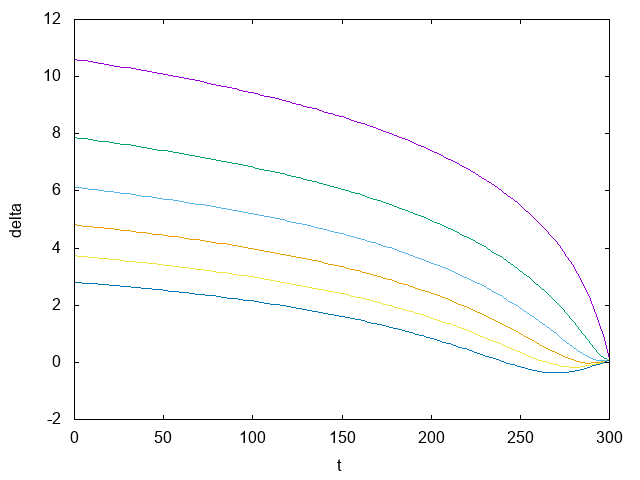

In [7]:
// plot the figure
{
    // add labels on the x/y axis
    std::stringstream ss("set xlabel \"t\"\n set ylabel \"delta\"");
    // put the plot in figure1
    figure = G.plotData(x,z,&ss);
}
// show figure
figure

See the full code solution on github [click here](https://github.com/pjohno/MSc-Math-Finance-2018/blob/master/main/project-4-optimal-liquidation-all-in-one.cpp).